<a href="https://colab.research.google.com/github/turna1/CISC801-Topics-in-AI/blob/main/Studio_2_CISC801.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tips:

* Enable a GPU in Colab before running this notebook. *Edit -> Notebook settings -> Hardware accelerator -> GPU.*

* Should you need to reset your environment to a clean state, you can use *Runtime -> Factory reset runtime*.

Neural Networks with TensorFlow

Welcome! Today, you'll gain hands-on experience training neural networks with TensorFlow. This notebook contains several tutorials and exercises. Your instructor will guide you through the sections you'll explore today.

If you're new to Deep Learning, this is a *lot* of material to cover in a short workshop. Our goals are to dive in and get started. You'll find educational resources for you to continue learning at the end, and you can complete the sections we don't finish today at home.

Here's an outline of what we'll cover.

1. You'll train a Deep Neural Network to classify handwritten digits. This is the "hello world" of computer vision, and a great place to begin if you're new to the subject. As an exercise, you'll use a different dataset, and modify the network.

1. Next, you'll train a Convolutional Neural Network to classify images of cats and dogs, using a real-world dataset you read off disk. As an exercise, you'll use data augmentation and dropout to reduce overfitting.

1. If time remains, your instructor will walk you through DeepDream. This is an advanced example that lets you visualize some of the features learned by a CNN.

Okay, let's get started!

# Tutorial: MNIST

Training an image classifier on the MNIST dataset of handwritten digits is considered the "hello world" of computer vision. In this tutorial, you will download the dataset, then train a linear model, a neural network, and a deep neural network to classify it.

**Key point:** Deep Learning is "code light, but concept heavy". You'll be able to implement a Deep Neural Network in about five lines of code, but the underlying concepts (cross-entropy, softmax, dense layers, etc) normally take a few months to learn. You do need to understand these all today to dive in.

## Import TensorFlow

Let's import TensorFlow. At the time of writing, Colab has TensorFlow version 1.x installed by default. TensorFlow 2.x is much easier to use, so let's start with that. To switch to 2.x we'll use the magic command below. Note, you can also [install](http://tensorflow.org/install) TensorFlow by using `pip`, but in Colab, the magic command is faster.

In [ ]:
import tensorflow as tf
print("You are using TensorFlow version", tf.__version__)
if len(tf.config.list_physical_devices('GPU')) > 0:
  print("You have a GPU enabled.")
else:
  print("Enable a GPU before running this notebook.")

You are using TensorFlow version 2.15.0
You have a GPU enabled.


Colab has a variety of GPU types available (each new  instance is assigned one randomly, depending on availability). To see which type of GPU you have, you can run ```!nvidia-smi``` in a code cell. Some are quite fast!

In [ ]:
# In this notebook, we'll use Keras: TensorFlow's user-friendly API to
# define neural networks. Let's import Keras now.
from tensorflow import keras
import matplotlib.pyplot as plt

## Download the MNIST dataset
MNIST contains 70,000 grayscale images in 10 categories. The images are low resolution (28 by 28 pixels). An important skill in Deep Learning is exploring your dataset, and understanding the format. Let's download MNIST, and explore it now.

In [ ]:
dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = dataset.load_data()

11490434/11490434 [==============================] - 0s 0us/step


There are 60,000 images in the training set:

In [ ]:
print(train_images.shape)

(60000, 28, 28)


And 10,000 in the testing set:

In [ ]:
print(test_images.shape)

(10000, 28, 28)


Each label is an integer between 0-9:

In [ ]:
print(train_labels)

[5 0 4 ... 5 6 8]


## Preprocess the data
The pixel values in the images range between 0 and 255. Let's normalize the values 0 and 1 by dividing all the images by 255. It's important that the training set and the testing set are preprocessed in the same way.

In [ ]:
train_images = train_images / 255.0
test_images = test_images / 255.0

Let's display the first 25 images from the training set, and display the label below each image.

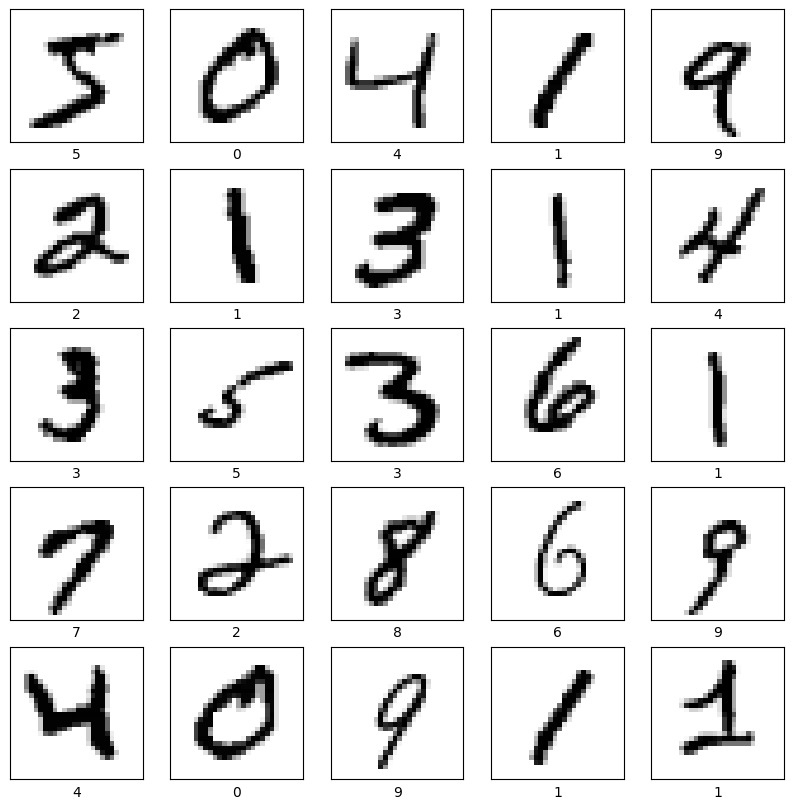

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

## Create the layers

Neural networks are made up of layers. Here, you'll define the layers, and assemble them into a model. We will start with a single Dense layer.

### What does a layer do?

The basic building block of a neural network is the layer. Layers extract representations from the data fed into them. For example:

- The first layer in a network might receives the pixel values as input. From these, it learns to detect edges (combinations of pixels).

- The next layer in the network receives edges as input, and may learn to detect lines (combinations of edges).

- If you added another layer, it might learn to detect shapes (combinations of edges).

The "Deep" in "Deep Learning" refers to the depth of the network. Deeper networks can learn increasingly abstract patterns. Roughly, the width of a layer (in terms of the number of neurons) refers to the number of patterns it can learn of each type.

Most of deep learning consists of chaining together simple layers. Most layers, such as [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), have parameters that are initialized randomly, then tuned (or learned) during training by gradient descent.

In [ ]:
# A linear model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(10, activation='softmax')
])

The first layer in this network, [tf.keras.layers.Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten), transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data. This is necessary since Dense layers require arrays as input.

After the pixels are flattened, this model consists of a single Dense layer. This is a densely connected, or fully connected, neural layer. The Dense layer has 10 neurons with softmax activation. This returns an array of 10 probability scores that sum to 1.

After classifying an image, each neuron will contains a score that indicates the probability that the current image belongs to one of the 10 classes.

## Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's compile step:

*Loss function* — This measures how accurate the model is during training. You want to minimize this function to "steer" the model in the right direction.

*Optimizer* — This is how the model is updated based on the data it sees and its loss function.

*Metrics* — Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Train the model
Training the neural network model requires the following steps:

1. Feed the training data to the model. In this example, the training data is in the ```train_images``` and ```train_labels``` arrays.

1. The model learns to associate images and labels.

1. You ask the model to make predictions about a test set—in this example, the ```test_images``` array.

1. Verify that the predictions match the labels from the ```test_labels``` array.

To begin training, call the ```model.fit``` method — so called because it "fits" the model to the training data:

In [ ]:
EPOCHS=10
model.fit(train_images, train_labels, epochs=EPOCHS)

Epoch 1/10
1875/1875 [==============================] - 9s 3ms/step - loss: 0.4738 - accuracy: 0.8763
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3042 - accuracy: 0.9150
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2836 - accuracy: 0.9209
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2736 - accuracy: 0.9240
Epoch 5/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2668 - accuracy: 0.9260
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2623 - accuracy: 0.9275
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2586 - accuracy: 0.9284
Epoch 8/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2556 - accuracy: 0.9293
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2533 - accuracy: 0.9298
Epoch 10/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.250

As the model trains, the loss and accuracy metrics are displayed. This model reaches an accuracy of about 0.90 (or 90%) on the training data. Accuracy may be slightly different each time you run this code, since the parameters inside the Dense layer are randomly initialized.

## Evaluate accuracy
Next, compare how the model performs on the test dataset:

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy:', test_acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.2686 - accuracy: 0.9267

Test accuracy: 0.9266999959945679


It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents overfitting. Overfitting is when a machine learning model performs worse on new, previously unseen inputs than on the training data. An overfitted model "memorizes" the training data—with less accuracy on testing data.

## Make predictions
With the model trained, you can use it to make predictions about some images.

In [ ]:
predictions = model.predict(test_images)

313/313 [==============================] - 1s 2ms/step


Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [ ]:
print(predictions[0])

[5.95945494e-07 2.62458154e-12 2.52686118e-06 6.40807254e-03
 1.72483894e-07 1.92324496e-05 4.61645132e-12 9.93247867e-01
 1.43615325e-05 3.07100039e-04]


A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 10 digits. You can see which label has the highest confidence value:

In [ ]:
print(tf.argmax(predictions[0]))

tf.Tensor(7, shape=(), dtype=int64)


# Exercise: Fashion MNIST

In the above tutorial, you trained a linear model (a single Dense layer) on the MNIST dataset. As an exercise, let's modify your code above to:
- Use a new dataset (Fashion MNIST)
- Train a neural network (with two Dense layers, instead of just one)
- Create plots to observe overfitting and underfitting

## Instructions

You will need to make two changes in the code above.

**1) Import the Fashion MNIST**

To do so, change the line

```
dataset = keras.datasets.mnist
```

to

```
dataset = keras.datasets.fashion_mnist
```

**2) Modify the model definition to create a neural network**

To do so, change the lines from:

```
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(10, activation='softmax')
])
```

to

```
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
```

This will define a neural network with a single hidden layer. If you like, you can experiment by adding a third Dense layer, which will create a deep neural network. For example:

```
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
```

After making the above changes, on the Colab menu   select *Edit -> Clear all outputs* and *Runtime -> Restart runtime* to restore this notebook to a clean state. Run the cells in the tutorial above to train your neural network on Fashion MNIST.

**3) Add plots to observe overfitting**

If trained for too long, a NN may begin to memorize the training data (rather than learning patterns that generalize to unseen data). This is called overfitting. Of all the hyperparmeters in the design of your network (the number and width of layers, the optimizer, etc) - the most important to set properly is ```epochs```. You will learn more about this in exercise two.

To create plots to observe overfitting, modify your training loop as follows.

Change:

```
history = model.fit(train_images, train_labels, epochs=EPOCHS)
```

to:

```
history = model.fit(train_images, train_labels,
                    validation_data=(test_images, test_labels),
                    epochs=EPOCHS)
```

This will capture the accuracy and loss on the training and validation data after epoch. To plot the results, create a new code cell, and add the following code:

```
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
```



In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Game break: Teachable Machine
If you'd like, now would be a good time to take a break from coding and try: https://teachablemachine.withgoogle.com/

# Tutorial: Cats and Dogs
Your instructor will walk you through this section (please follow along and ask questions as you have them!). You'll train a CNN to classify images of cats and dogs using a real-world dataset you will download from the web.

 ## Download and explore the dataset

Although you are downloading large files, you are doing so in Colab through Google Cloud Platform (instead of over your local WiFi connection). This means that downloads will usually be fast, regardless of your internet connection.

In [ ]:
import os

In [ ]:
# Our dataset is a zip on the web
origin = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=origin, extract=True)
path_to_folder = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

The unzipped dataset has the following directory structure:

<pre>
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

The dataset is divided into train and validation splits. Let's create variables that point to each of these directories.

In [ ]:
train_dir = os.path.join(path_to_folder, 'train')
validation_dir = os.path.join(path_to_folder, 'validation')

In [ ]:
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Now let's count the number of images in each directory.

In [ ]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

print('Total training cat images:', num_cats_tr)
print('Total training dog images:', num_dogs_tr)
print('Total validation cat images:', num_cats_val)
print('Total validation dog images:', num_dogs_val)
print('---')
print("Total training images:", total_train)
print("Total validation images:", total_val)

You should see that we have 3,000 total images (2,000 in train and 1,000 in validation). Note that this dataset is balanced (we have an equal number of cats and dogs).

Tip: in addition to Python, you can run shell commands in Colab (for example, ```!ls $train_cats_dir```).

In [ ]:
!ls $train_cats_dir

Let's display a couple images.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
_ = plt.imshow(plt.imread(os.path.join(train_cats_dir, "cat.0.jpg")))

In [ ]:
_ = plt.imshow(plt.imread(os.path.join(train_cats_dir, "cat.1.jpg")))

Note that the images are different sizes. Before feeding them into a CNN, we'll need to reshape them all to the same dimensions. We'll take care of that in the next section.

## Data preprocessing

Next, we will need a way to read these images off disk, and to preprocess them. Specifically, we will need to:
- Read the image off disk.
- Decode contents of these images and convert them into RGB arrays.
- Convert the pixels values from integer to floating point types.
- Rescale the pixel from values between 0 and 255 to values between 0 and 1 (neural networks work better with small input values - under the hood, each input is multiplied by a weight, large inputs could result in overflow).

Fortunately, all of these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`. It can read images from disk and preprocess them into proper arrays.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Let's resize images to this size
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [ ]:
# Rescale the pixel values to range between 0 and 1
train_generator = ImageDataGenerator(rescale=1./255)
val_generator = ImageDataGenerator(rescale=1./255)

After defining the generators for training and validation images, the `flow_from_directory` method load images from the disk, applies rescaling, and resizes the images into the required dimensions.

In [ ]:
batch_size = 32 # Read a batch of 64 images at each step

In [ ]:
train_data_gen = train_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

In [ ]:
val_data_gen = val_generator.flow_from_directory(batch_size=batch_size,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

## Use the generators to display a few images and their labels

Next, we will extract a batch of images from the training generator, then plot several of them with `matplotlib`. The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(x_train, y_train)` where x_train is the pixel values and y_train is the labels.

In [ ]:
image_batch, labels_batch = next(train_data_gen)

In [ ]:
# The shape will be (32, 150, 150, 3)
# This means a list of 32 images, each of which is 150x150x3.
# The 3 at the end refers to the R,G,B color channels.
# A grayscale image would be (for example) 150x150x1
print(image_batch.shape)

In [ ]:
# The shape (32,) means a list of 64 numbers
# each of these will either be 0 or 1
print(labels_batch.shape)

In [ ]:
# This function will plot images returned by the generator
# in a grid with 1 row and 5 columns
def plot_images(images):
  fig, axes = plt.subplots(1, 5, figsize=(10,10))
  axes = axes.flatten()
  for img, ax in zip(images, axes):
      ax.imshow(img)
      ax.axis('off')
  plt.tight_layout()
  plt.show()

In [ ]:
plot_images(image_batch[:5])

Next, let's retrieve the labels. All images will be labeled either 0 or 1, since this is a binary classification problem.

In [ ]:
# Here are the first 5 labels from the dataset
# that correspond to the images above
print(labels_batch[:5])

In [ ]:
# Here, we can see that "0" maps to cat,
# and "1" maps to dog
print(train_data_gen.class_indices)

## Create the model
Your model will consist of three convolutional blocks followed by max pooling. There's a fully connected layer with 256 units on top. This model will output class probabilities (between 0 and 1) based on the `sigmoid` activation function. If the output is closer to 1, the image will be classified as a dog, otherwise a cat.

In [ ]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential

In [ ]:
model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu',
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

Compile the model, and select the adam optimizer for gradient descent, and binary cross entropy for the loss function (roughly, cross entropy is a way to measure the distance between the prediction we wanted the network to make, and the prediction it made).

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Let's look at a diagram of all the layers of the network using the `summary` method:

In [ ]:
model.summary()

This model has about 5M parameters (or weights) to learn. Our model is ready to go, and next we can train it using the data generators we created earlier.

## Train the model

Use the `fit` method to train the network. You will train the model for 15 epochs (an epoch is one "sweep" over the training set, where each image is used once to perform a round of gradient descent, and update the models parameters). This will take one to two minutes, so let's start it now:

In [ ]:
epochs = 15

In [ ]:
history = model.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=val_data_gen,
)

Inside `model.fit`, TensorFlow uses gradient descent to find useful values for all the weights in the model. When you create the model, the weights are initialized randomly, then gradually improved over time. The data generator is used to load batches of data off disk. Then, for each batch:
- The model performs a forward pass (the images are classified by the network).
- Then, the model performs a backward pass (the error is computed, then each weight is slightly adjusted using gradient descent to improve the accuracy on the next iteration).

Gradient descent is an iterative process. The longer you train the model, the more accurate it will become on the training set. But, the more likely it is to overfit! Meaning, the model will begin to memorize the training images, rather than learn patterns that enable it generalize to new images not included in the training set.

- We can see whether overfitting is present by comparing the accuracy on the training and validation data.

If you look at the accuracy figures reported above, you should see that training accuracy is over 90%, while validation accuracy is only around 70%.

## Create plots to check for overfitting
Accuracy on the validation data is important: it helps you estimate how well our model is likely to work on new, unseen data in the future. To see how much overfitting is present (and when it occurs), we will create two plots, one for accuracy, and another for loss. Roughly, loss (or error) is the inverse of accuracy (lower is better). Unlike accuracy, loss takes the confidence of a prediction into account (a confidently wrong predicitions has a higher loss than one that is only slightly wrong).

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Overfitting occurs when the validation loss stops decreasing. In this case, that occurs around epoch 5 (give or take). Your results may be slightly different each time you run this code (since the weights are initialized randomly).

Why does overfitting happen? When there are only a "small" number of training examples, the model sometimes learns from noises or unwanted details, to an extent that it negatively impacts the performance of the model on new examples. It means that the model will have a difficult time "generalizing" on a new dataset (making accurate predictions on images that weren't included in the training set).

# Game break: Quick, Draw!
If you'd like, now would be a good time to take a break from coding and try: https://quickdraw.withgoogle.com/

# Exercise: Reduce overfitting

## Instructions

In this exercise, you will use data augmentation and dropout to improve your model. Follow along by reading and running the code below. There are two **TODOs** for you to complete, and a solution is given below.

## Data augmentation
Overfitting occurs when there are a "small" number of training examples. One way to fix this problem is to increase the size of the training set, by gathering more data (the larger and more diverse the dataset, the better!)

We can also use a technique called "data augmentation" to increase the size of the training set, by generating new examples from existing ones by applying random transformations (for example, rotation) that yield believable-looking images.

This is especially effective when working with images. For example, our training set may only contain images of cats that are right side up. If our validation set contains images of cats that are upside down, our model may have trouble classifying them correctly. To help teach it that cats can appear in any orientation, we will randomly rotate images from our training set during training. This helps expose the model to more aspects of the data, and can lead to better generalization.

Data augmentation is built into the ImageDataGenerator. You can specifiy different transformations, and it will take care of applying then during the training.

In [ ]:
# Let's create new data generators, this time with
# data augmentation enabled
train_generator = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

In [ ]:
train_data_gen = train_generator.flow_from_directory(batch_size=32,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

The next cell will show how the same training image appears when used with five different types of data augmentation.

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plot_images(augmented_images)

We only apply data augmentation to the training examples, so our validation generator looks the same as before.

In [ ]:
val_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
val_data_gen = val_generator.flow_from_directory(batch_size=32,
                                                 directory=validation_dir,
                                                 target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                 class_mode='binary')

## Dropout

Another technique to reduce overfitting is to introduce dropout to the network. Dropout is a form of regularization that makes it more difficult for the network to memorize rare details (instead, it is forced to learn more general patterns).

When you apply dropout to a layer it randomly drops out (set to zero) a number of activations during training. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

When appling 0.1 dropout to a certain layer, it randomly deactivates 10% of the output units in each training epoch.

Create a new model using Dropout. You'll reuse the model definition from above, and add a Dropout layer.

In [ ]:
from tensorflow.keras.layers import Dropout

In [ ]:
# TODO: Your code here
# Create a new CNN that takes advantage of Dropout.
# 1) Reuse the model declared in tutorial above.
# 2) Add a new line that says "Dropout(0.2)," immediately
# before the line that says "Flatten()".

## Solution


In [ ]:
#@title
model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu',
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])

After introducing dropout to the network, compile your model and view the layers summary. You should see a Dropout layer right before flatten.

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

## Train your new model
Add code to train your new model. Previously, we trained for 15 epochs. You will need to train this new modek for more epochs, as data augmentation and dropout make it more difficult for a CNN to memorize the training data (this is what we want!).

Here, you'll train this model for 25 epochs. This may take a few minutes, and you may need to train it for longer to reach peak accuracy. If you like, you can continue experimenting with that at home.

In [ ]:
epochs = 25

In [ ]:
# TODO: your code here
# Add code to call model.fit, using your new
# data generators with image augmentation
# For reference, see the "Train the model"
# section above

## Solution

In [ ]:
#@title
history = model.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=val_data_gen,
)

## Evaluate your new model
Finally, let's again create plots of accuracy and loss (we use these plots often in practice!) Now, compare the loss and accuracy curves for the training and validation data. Were you able to achieve a higher validation accuracy than before? Note that even this model will eventually overfit. To prevent that, we use a technique called early stopping (we stop training when the validation loss is no longer decreasing).

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Game break: Sketch-RNN
If you'd like, now would be a good time to take a break from coding and try: https://magenta.tensorflow.org/assets/sketch_rnn_demo/index.html

# Exercise: Flowers

In this exercise, you write a CNN and use it to classify five different types of flowers (sunflowers, tulips, etc). The dataset contains 1000 images in the training set, and 500 in the validation set.

You will download the dataset, read and preprocess the images using ImageDataGenerator, then create, train and evaluate a model.

A code outline is written for you, and there are several sections for you to complete, using the same pattern as the tutorial above.

### Download the dataset

In [ ]:
origin = 'https://storage.googleapis.com/tensorflow-blog/datasets/mini_flowers.zip'
path_to_zip = tf.keras.utils.get_file('mini_flowers.zip', origin=origin, extract=True)
path_to_folder = os.path.join(os.path.dirname(path_to_zip))

train_dir = os.path.join(path_to_folder, "train/")
val_dir = os.path.join(path_to_folder, "val/")

### Read the images off disk

In [ ]:
train_image_generator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=32,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='categorical')

### Plot images and their labels

In [ ]:
image_batch, labels_batch = next(train_data_gen)

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_batch[i])
    plt.xlabel(str(labels_batch[i]))
plt.show()

## Understanding one-hot labels

Notice the labels are in one-hot format. Let's add some code to display the class names.

In [ ]:
print(train_data_gen.class_indices)

In [ ]:
class_names = {v:k for k,v in train_data_gen.class_indices.items()}

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image_batch[i])
  plt.xlabel(class_names[tf.argmax(labels_batch[i]).numpy()])
plt.show()

## Read the validation images

In [ ]:
# Above, you created a ImageDataGenerator for the training set
# Next, create one to read the validation images
# For example:
# validation_image_generator = ImageDataGenerator ...
# val_data_gen = validation_image_generator.flow_from_directory ...

## Create a CNN

Now, it's time to define your model. You can create a similar model to the CNN used in the tutorial above.

The only difference is that the final Dense layer of your model (which classifies the data based on the features provided by the convolutional base) must use softmax activation and have five output classes:

```model.add(Dense(5, activation='softmax'))```

This is because we now have five different types of flowers, instead of just cats and dogs.

In [ ]:
# TODO: your code here
# Define a CNN using code similar to the above
# For example
# model = Sequential()
# model.add ...
# ...
# The last line of your model should be:
# model.add(Dense(5, activation='softmax'))

After you have defined your model, compile it by uncommenting and running this code. Important: notice that the loss has changed to ```categorical_crossentropy```. This is necessary because the labels are in one-hot format. Finally, although these loss functions sound complicated, there are only a handful for you to learn.


In [ ]:
#model.compile(optimizer='adam',
#              loss='categorical_crossentropy',
#              metrics=['accuracy'])

Now train your model for 10 epochs using ```model.fit```. If you like, you can try to create plots of the training and validation accuracy and loss.

In [ ]:
# TODO: your code here
# For example
# model.fit ...

If all has gone well, your model should be about 90% accurate on the training data.

## Solution

```
# Read the validation images
validation_image_generator = ImageDataGenerator(rescale=1./255)
val_data_gen = validation_image_generator.flow_from_directory(batch_size=32,
                                                              directory=val_dir,
                                                              shuffle=True,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='categorical')
```

```
# Define a model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))
```

```
# Train the model
history = model.fit(
    train_data_gen,
    epochs=10,
    validation_data=val_data_gen,
)
```

# An advanced example: DeepDream
If time remains, in this tutorial your instructor will walk you through a minimal version of DeepDream, an experiment to visualize some of the features a convolutional neural network has learned to detect. DeepDream is an advanced tutorial, and our goal is to introduce you to some of the fascinating (and unexpected) things you can explore with Deep Learning.

Normally, when training a model we use gradient descent to minimize classification loss. In a CNN, this means we adjust the weights in the filters. In DeepDream, we start with a large, pretrained CNN (and leave the filters fixed!) We then use gradient descent to modify the input image to increasingly activate the filters. For example, if there is a filter that recognizes a certain kind of texture, we can progressively modify the image to contain more and more examples of that texture.

In [ ]:
import numpy as np
from IPython.display import clear_output

## Download and display an image

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

In [ ]:
def download(url, target_size=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  return tf.keras.preprocessing.image.load_img(image_path, target_size)

def show(img):
  plt.figure(figsize=(8,8))
  plt.grid(False)
  plt.axis('off')
  plt.imshow(img)
  plt.show()

original_img = download(url, target_size=[225, 375])
original_img = np.array(original_img)
show(original_img)

## Rescale the pixel values

In [ ]:
def preprocess(img):
  """ Convert RGB values from [0, 255] to [-1, 1] """
  img = tf.cast(img, tf.float32)
  img /= 128.0
  img -= 1.
  return img

def unprocess(img):
  """ Undo the preprocessing above """
  img = 255 * (img + 1.0) / 2.0
  return tf.cast(img, tf.uint8)

## Import a large, pretrained CNN
This model has been trained on ImageNet, a dataset with about 1M images in about 1K classes

In [ ]:
conv_base = tf.keras.applications.InceptionV3(weights='imagenet',
                                              include_top=False)

## Choose layers to activate
Normally, when you train a neural network, you use gradient descent to adjust the weights to minimize loss, in order to accurately classify images. In DeepDream, the trick is to use gradient descent to adjust the **image**, in order to increasingly activate certain layers from the network. You can explore different layers and see how this affects the results. You can find all the layer names using ```model.summary()```.

In [ ]:
names = ['mixed2', 'mixed3', 'mixed4', 'mixed5']
layers = [conv_base.get_layer(name).output for name in names]
model = tf.keras.Model(inputs=conv_base.input, outputs=layers)

## Custom loss function
Normally, we would use cross-entropy loss (for classification), or mean squared error (for regression). Here, we'll write a loss function that describes how activated our layers were by the image.

In [ ]:
def calc_loss(img):
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  losses = [tf.math.reduce_mean(act) for act in layer_activations]
  return tf.reduce_sum(losses)

## Use gradient ascent to progressively activate the layers
Normally, when training a model you use gradient *descent* to adjust the weights to reduce the loss. In DeepDream, you will use gradient *ascent* to maximize the activation of the layers you selected by modifying the image, while leaving the weights of the network fixed.

In [ ]:
@tf.function
def step(img, lr=0.001):
  with tf.GradientTape() as tape:
    loss = calc_loss(img)

  gradients = tape.gradient(loss, img)
  gradients /= tf.math.reduce_std(gradients) + 1e-8

  # Because the gradients are in the same shape
  # as the image, we can directly add them to it!
  img.assign_add(gradients * lr)
  img.assign(tf.clip_by_value(img, -1, 1))

In [ ]:
img = tf.Variable(preprocess(original_img))

steps = 1000
for i in range(steps):
  step(img)
  if i % 200 == 0:
    clear_output(wait=True)
    print ("Step {}".format(i))
    show(unprocess(img.numpy()))

clear_output(wait=True)
show(unprocess(img.numpy()))

You can find a complete example on the [website](https://www.tensorflow.org/tutorials/generative/deepdream) (which includes additional code to generate less noisy images), and you may also be interested in exploring a related technique [Neural Style Transfer](https://www.tensorflow.org/tutorials/generative/style_transfer).

# Stay in touch

- Twitter https://twitter.com/tensorflow
- Blog http://blog.tensorflow.org/
- YouTube https://www.youtube.com/tensorflow.

Thank you!

# Learning more

Book recommendations
* [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python)
* [Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)
